<a href="https://colab.research.google.com/github/ShawnDong98/GAN/blob/master/WGAN/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [2]:
# 数据根目录
dataroot = "data/"

# dataloader的进程数
workers = 2

# 训练时的batch_size
batch_size = 32

# 训练时图像的尺寸，所有图像都会被拉到这个尺寸
image_size = 64

# 训练图像的通道数
nc = 3

# 隐向量的大小，也就是噪声z，也就是生成器的输入
nz = 100

# 生成器的特征映射大小
ngf = 64

# 判决器的特征映射大小
ndf = 64

# 训练epotch的次数
num_epochs = 50

# 优化器的学习率
lr = 0.00005

# Adam优化器的超参数
beta1 = 0.5

# 可用GPU的数量
ngpu = 1

clamp_num=0.01# WGAN clip gradient

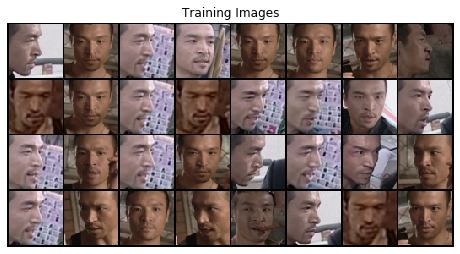

In [3]:
# data preprocess
transform=transforms.Compose([
                transforms.Resize(image_size) ,
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3,[0.5]*3)
                ])

dataset = dset.ImageFolder(root=dataroot,
                transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),                
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
               ]))
# dataloader with multiprocessing
dataloader=torch.utils.data.DataLoader(dataset,
                                   batch_size,
                                   shuffle = True,
                                   num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [7]:

optimizerD = optim.RMSprop(netD.parameters(),lr=lr ) 
optimizerG = optim.RMSprop(netG.parameters(),lr=lr )


fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
lossD = 0
lossG = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
        # 训练判决器
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        ## 因为autograd只能标量对标量，标量对向量和矩阵求导，所以这里求个mean
        real_loss = torch.mean(netD(real_cpu))
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise).detach()
        fake_loss = torch.mean(netD(fake))
        netD.zero_grad()
        lossD = real_loss - fake_loss
        lossD.backward()
        optimizerD.step()
        
        if (i+1)%5==0:
            netG.zero_grad()
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            lossG = torch.mean(netD(netG(noise)))
            lossG.backward()
            optimizerG.step()
            
        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(dataloader),
                     lossD, lossG))
            
        # Save Losses for plotting later
        G_losses.append(lossG)
        D_losses.append(lossD)
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1   
        

Starting Training Loop...
[0/50][0/25]	Loss_D: -1.3457	Loss_G: 0.0000	
[0/50][5/25]	Loss_D: -1.3495	Loss_G: 0.6454	
[0/50][10/25]	Loss_D: -1.3468	Loss_G: 0.6476	
[0/50][15/25]	Loss_D: -1.3637	Loss_G: 0.6501	
[0/50][20/25]	Loss_D: -1.3770	Loss_G: 0.6577	
[1/50][0/25]	Loss_D: -1.3675	Loss_G: 0.6577	
[1/50][5/25]	Loss_D: -1.3639	Loss_G: 0.6595	
[1/50][10/25]	Loss_D: -1.3764	Loss_G: 0.6614	
[1/50][15/25]	Loss_D: -1.3765	Loss_G: 0.6622	
[1/50][20/25]	Loss_D: -1.3946	Loss_G: 0.6638	
[2/50][0/25]	Loss_D: -1.3906	Loss_G: 0.6659	
[2/50][5/25]	Loss_D: -1.4052	Loss_G: 0.6692	
[2/50][10/25]	Loss_D: -1.3966	Loss_G: 0.6681	
[2/50][15/25]	Loss_D: -1.3945	Loss_G: 0.6713	
[2/50][20/25]	Loss_D: -1.4009	Loss_G: 0.6723	
[3/50][0/25]	Loss_D: -1.2705	Loss_G: 0.6359	
[3/50][5/25]	Loss_D: -1.4053	Loss_G: 0.6723	
[3/50][10/25]	Loss_D: -1.4092	Loss_G: 0.6778	
[3/50][15/25]	Loss_D: -1.4151	Loss_G: 0.6785	
[3/50][20/25]	Loss_D: -1.4212	Loss_G: 0.6783	
[4/50][0/25]	Loss_D: -1.4116	Loss_G: 0.6834	
[4/50][5/25]	Loss

[35/50][10/25]	Loss_D: -1.2891	Loss_G: 0.6429	
[35/50][15/25]	Loss_D: -1.3098	Loss_G: 0.6534	
[35/50][20/25]	Loss_D: -1.3054	Loss_G: 0.6397	
[36/50][0/25]	Loss_D: -1.2619	Loss_G: 0.6476	
[36/50][5/25]	Loss_D: -1.3026	Loss_G: 0.6481	
[36/50][10/25]	Loss_D: -1.2641	Loss_G: 0.6266	
[36/50][15/25]	Loss_D: -1.3256	Loss_G: 0.6478	
[36/50][20/25]	Loss_D: -1.3047	Loss_G: 0.6412	
[37/50][0/25]	Loss_D: -1.0995	Loss_G: 0.5387	
[37/50][5/25]	Loss_D: -1.3251	Loss_G: 0.6455	
[37/50][10/25]	Loss_D: -1.2981	Loss_G: 0.6460	
[37/50][15/25]	Loss_D: -1.3214	Loss_G: 0.6329	
[37/50][20/25]	Loss_D: -1.2431	Loss_G: 0.6261	
[38/50][0/25]	Loss_D: -1.2730	Loss_G: 0.6510	
[38/50][5/25]	Loss_D: -1.3287	Loss_G: 0.6450	
[38/50][10/25]	Loss_D: -1.2958	Loss_G: 0.6388	
[38/50][15/25]	Loss_D: -1.3383	Loss_G: 0.6436	
[38/50][20/25]	Loss_D: -1.3128	Loss_G: 0.6488	
[39/50][0/25]	Loss_D: -1.2995	Loss_G: 0.6367	
[39/50][5/25]	Loss_D: -1.2655	Loss_G: 0.6468	
[39/50][10/25]	Loss_D: -1.3457	Loss_G: 0.6553	
[39/50][15/25]	Loss_D

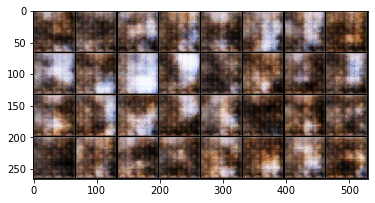

In [17]:
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))

In [3]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00005, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_known_args()[0]
print(opt)

Namespace(batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=5e-05, n_cpu=8, n_critic=5, n_epochs=200, sample_interval=400)
